*Nicole Mathias*

Instructions to run the notebook


*   Add exercise.ipynb and content.csv to your drive (to specific folder) - my code will add it to a folder automatically.

# Welcome to our ML project!

This is a quick exercise to help demonstrate your familiarity with RAG systems - one might say that this is a place where you can b**RAG** about your skills! 🤣

In this exercise, you will be asked to build a simple RAG system that answer some provided questions using the dataset provided. We expect this exercise to take 1-3 hours TOPS so use that to temper your approach to building this. We're not looking for reusable or production-level code - we're expressly looking for you to show us that you:

* can explore an unknown dataset
* can use an LLM (in this case, OpenAI's GPT-3) to build a simple RAG system

## The Dataset

You'll find the dataset in `content.csv`. It is a set of content about companies that has been scraped from the web. It contains the following columns:

* `company_id`: a unique identifier for the company (UUID)
* `company_name`: the name of the company
* `url`: the URL from which the content was scraped
* `chunk`: a chunk of the content that was scraped from the `url`
* `chunk_hash`: a hash of the chunk
* `chunk_id`: a unique identifier for the chunk of content
* `chunk_type`: the type of the chunk of content (e.g. `header`, `footer`)


Here's an example:

|company_id|company_name|url|chunk_type|chunk_hash|chunk|chunk_id|
|---|---|---|---|---|---|---|
|4c1fde18-8a40-4ee7-9c3c-19152c7d1ff8|Aboitiz Group|https://aboitiz.com/about-us/the-aboitiz-way/|head|d312f0c688076be80ee2e4af8a51c2f10cbb993a4a8de779cb4aa5545fe1051f|"<head>Aboitiz - The Aboitiz Way</head>"|be36e2f0-cd0b-42eb-b36d-c9403c2428be|

## Step 1: Explore the dataset

Here are some questions that we'd like you to answer about the dataset:

1. How many companies are in the dataset?
2. How many unique URLs are in the dataset?
3. What is the most common chunk type?
4. What is the distribution of chunk types by company?

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install openai

In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import shutil

# The below code will move content.csv and exercise.ipynb to a specific folder
# Just upload both the files to your drive (No need to add them to a folder, its all handled below)
folder_path = "/content/drive/MyDrive/gradient_works_data"
csv_file_path = "/content/drive/MyDrive/content.csv"
py_file_path = "/content/drive/MyDrive/exercise.ipynb"

if not os.path.exists(folder_path):
  os.makedirs(folder_path)

  shutil.move(py_file_path, folder_path)
  shutil.move(csv_file_path, folder_path)


os.chdir(folder_path)

In [143]:
# reading data from csv
df = pd.read_csv('content.csv')

### PART 1 Questions

In [ ]:
# 1. How many companies are in the dataset?
no_companies = len(df['company_name'].unique())
print("No. of Companies:",no_companies)

No. of Companies: 75


In [ ]:
# 2. How many unique URLs are in the dataset?
no_url = len(df['url'].unique())
print("No. of unique URL's",no_url)

No. of unique URL's 530


In [ ]:
# 3. What is the most common chunk type?
most_common_chunk = df['chunk_type'].mode().item()
print("Most common chunk:",most_common_chunk)

Most common chunk: header


In [ ]:
# 4. What is the distribution of chunk types by company?

# - group by companies and then for each company group get the count of chunk_types
chunk_types = df.groupby("company_name")["chunk_type"].value_counts()

chunk_grp_count = chunk_types.unstack(fill_value=0)
chunk_grp_count

chunk_type,footer,head,header,main
company_name,,,,
24Hrbookkeeper,0,1,0,1
365games.net,10,11,11,11
4wheeltravels.com,0,2,0,2
579twu.org,0,11,0,11
66corporation.com,4,4,4,4
...,...,...,...,...
bhatiagraphica.com,5,5,7,0
bijvoorbeeldzo,11,11,11,11
bikesandmunchies.com,9,9,9,0


<Axes: title={'center': 'Distribution of Chunk Types by Company'}, xlabel='Company name', ylabel='Count by chunk type'>

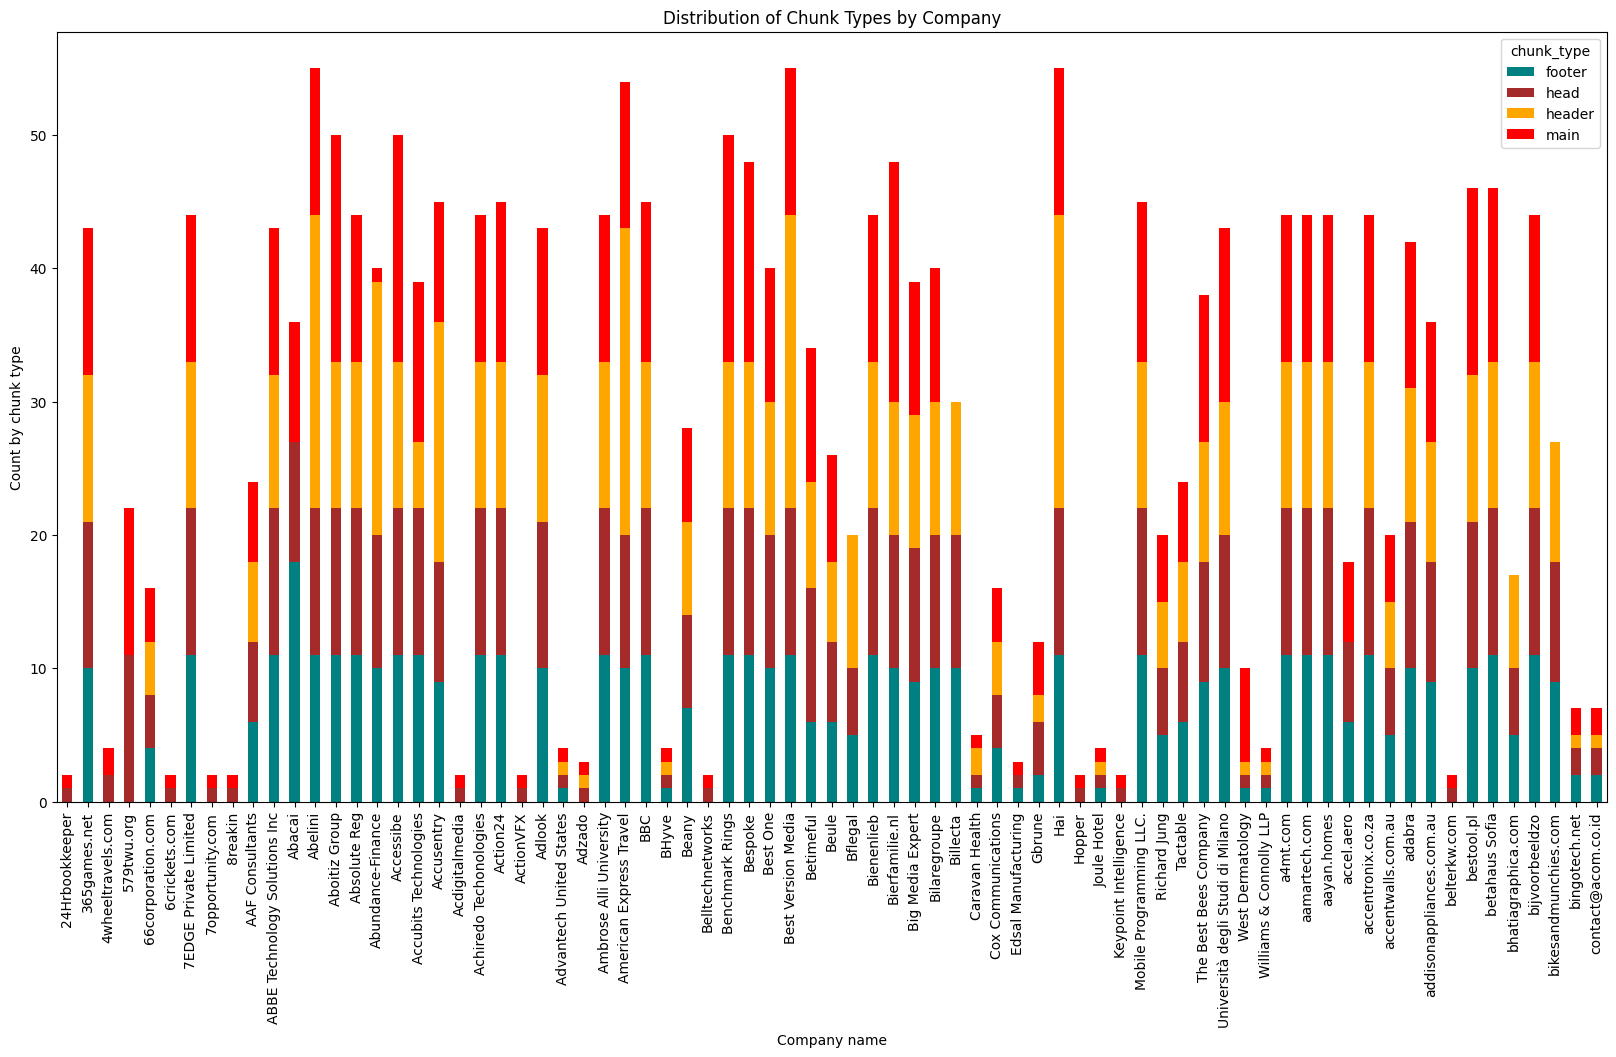

In [ ]:
# Creating a plot for Q.4
colors = ['teal', 'brown', 'orange', 'red']

chunk_grp_count.plot(kind='bar', stacked=True, color=colors,
                     xlabel='Company name',
                     ylabel='Count by chunk type',
                     title='Distribution of Chunk Types by Company',
                     figsize=(20,10)
                     )

## Step 2: RAGtime!

Now that you're a little more familar with the dataset, let's build a simple RAG system that uses OpenAI to help answer some questions about the dataset. To reiterate, we don't expect you to add anything else to the environment to build this system - for example, you don't need to set up a database or anything like that. You can add any libraries you need to the environment, but we'd like you to use OpenAI for any and all tasks that require a language model (we'll send you a key to use).

That being said, we'd like you to show the specifics of how a RAG implementation works so please avoid using any libraries that provide end-to-end RAG implementations.

Here is the question that we'd like you to answer via your RAG system:

1. What does the company Caravan Health do?

In [ ]:
# Steps for preparing the model:
# 1) Getting data & cleaning it - Cleaning can invloving preprocessing like removing stop-words and other information retrieval techniques.
# 2) Chunking logic - based on token size of the embedding and LLM model
# 3) Embedding the chunks

# Steps for query
# 1) Getting the query
# 2) If query is too long - chunk it
# 3) Embed the query

# Similarity and scoring mechanism
# 1) Find the similarity scores (cosine) between query embeddings and the chunk embeddings
# 2) Based on the scores, retrieve top k docs

# Generating answers
# 1) Use the top k documents as context and provide it to the LLM model

### Data Scraping - Retrieving data from HTML tags

- Using Beautiful soup to parse the html tags and obtain data.
- There are other tools like selenium as well

In [ ]:
%pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
# function to parse html tags and extract data
def text_cleaner():
  df['desc'] = ''

  for idx in range(len(df)):
    chunk_content = df['chunk'][idx]
    company_name = df['company_name'][idx]

    content = BeautifulSoup(chunk_content,'lxml')

    text_content = content.get_text(separator = '\n', strip = True)
    df['desc'][idx] = company_name + " " + text_content

In [ ]:
text_cleaner()
print("---Html data was cleaned---")

---Html data was cleaned---


### Chunking logic


*   Chunking is being performed in order to create list of tokens - that can be fed to the embedding model.

*   Embedding models have different token sizes and we can develop a chunking logic based on the specific embedding model and LLM, but to keep it simple I will use a token size = 512 (most of the models use 512 size size currently. So this code can be easily mapped to other embedding models if required - I would want to try more models and experiment to make a conclusion)

* I made the above point because, based on analysis there were chunks in languages other than English as well, so a multi-lingual model would be required for it - so it is safe to use a size of 512



**Additional text preprocessing steps can be performed:**


1.   Removal of stop-words (common words like a, the) which will improve query-document matching during retrieval.

2. Converting all the words to lowercase - might improve the embeddings.

3.   Using a bag of words model (used in NLP) is a simple way of using embeddings without a pretrained model









In [ ]:
import re

Data splitting logic:

1.   I am splitting every data chunk sentence-wise. (Splitting it paragraph-wise and then breaking it down would have been better for context: will look into this later)

2.   After I have my individual sentence - I split the sentence and check if the no. of token <= 512, then I keep it intact

3. If no. of tokens > 512, then I break the token list into smaller sublist's.

4. Also, experiments can be performed by changing the chunk size and chunk overlap which will help determine which setting workds best for our given task.

*The above logic is based on preserving context of the data, which is better than randomly splitting*


In [ ]:
def split_tokens(tokens, max_size):

  if not tokens:
      return []

  # If the length of tokens is less than or equal to max_size, return the tokens as a single sublist
  if len(tokens) <= max_size:
    return tokens

  # Split the tokens into two parts: the first max_size tokens and the rest
  first_part = tokens[:max_size]
  remaining_tokens = tokens[max_size:]

  # Recursively split the remaining tokens
  remaining_parts = split_tokens(remaining_tokens, max_size)

  # Combine the first part with the recursively split remaining parts
  return first_part + remaining_parts

**I wanted to come back and implement the overlap context feature below - but the creation of embeddings took more time than I imagined.**

*Advantage: This feature would be useful.
Remember, I had split the data based on sentences, but from my observation there were sentences which exceeded the max token limit of 512, so I broke the sentence into a sub-sentences.
The problem here is that these broken sentences loose context, and my idea of preserving the context was through overlapping some of the data*

In [ ]:
def create_chunks(max_size):
  max_size = max_size  # Maximum size for each sublist

  df['chunked_data'] = ''

  # overlapping data from previous context - I am keeping it fixed and can experiment with it later (this is the baseline)
  for idx in range(len(df)):
    # data_split = re.split(r'\.|\s+', df['desc'][idx]) # split the desc based on '.' or ' '
    data_split = re.split(r'\.',df['desc'][idx])

    sentence_chunks = []
    for sent in data_split:
      # calling the function to split and tokenize sentences
      sentence = " ".join(split_tokens(sent.split(), max_size))
      sentence_chunks.append(sentence)

    # df['chunked_data'][idx] = split_tokens(data_split, max_size)
    df['chunked_data'][idx] = sentence_chunks


In [ ]:
max_size = 512
create_chunks(max_size)

print("---Data has been chunked---")

---Data has been chunked---


saving the dataframe for a backup - this is not a necessary step


In [ ]:
# using pickle - which preserving the data perfectly, even json is another good option
import pickle
with open('df_pickle.pkl', 'wb') as f:
    pickle.dump(df, f)

 ### Embeddding Logic and getting top k docs


*   Saved the API auth key as a secret key named as auth_key



In [ ]:
%pip install openai

In [4]:
import openai

In [5]:
from google.colab import userdata
API_AUTH = userdata.get('auth_key')

In [6]:
openai.api_key = API_AUTH

In [7]:
# getting embeddings for the chunked data and saving them
def get_embedding(text_to_embed):
  # Embed the list of text
  response = openai.embeddings.create(
    model = "text-embedding-3-small",
    input = text_to_embed
  )

  # embeddings = []

  # for i in range(embed_len):
  #   embeddings.append(response.data[i].embedding)

  return response.data[0].embedding

In [ ]:
df['embeddings'] = ''
for idx in range(len(df)):
  embeddings_list = []

  for chunk in df['chunked_data'][idx]:
    embeddings_list.append(get_embedding(chunk))

  df['embeddings'][idx] = embeddings_list


**Since I am not creating a vector DB to store the embeddings, I will try to simulate it using simple file storage.**

* Created a pickle file which contains the embeddings and the source information.


*   My vector DB would contain - (chunk_id-unique attribute, embeddings)



*Advantage: Embeddings need to be created only once (only if we do not change the embedding model) - so I can store the current embeddings and keep adding new ones as more data is added to the system*

**Query Embeddings**

**Improvement:**
* Before Deep Learning models, the same tasks were performed using information retrieval systems (used in search engines as well)

* I propose a similar system - We can match the keywords of the query with the documents - there is a whole different technique of using bag of words as embeddings, word normalizations, creating dictionaries, scoring and retrieving the top k documents. I have worked on this task in the past and it works well (but not perfectly, nothing is) and is used in elastic search.

* Suggestion: We can use both embeddings and this information retrieval technique and then check which model has retrieved better documents and based on that use our LLM to prepare an answer.

In [8]:
query = "What does the company Caravan Health do?"
query_embedding = get_embedding(query)
# query_embedding

**Retrieving top k documents based on similarity scores**

* There are various scoring mechanisms which we can experiment with.
* I have used cosine score, because it is quick ( uses dot product in calculations) and relatively good.

**Improvement**: I would also re-rank the documents, because I know there were some chunks which did not have any data (i.e the html parser did not produce any data) - So I just added the company name as data for such cases. But at this point these documents are not so useful and it would rather make sense re-rank the documents and get better data.

In [ ]:
%pip install scikit-learn

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
# generating scores using cosine distance
def get_score(query, document):
  similarity = cosine_similarity(np.array(query).reshape(-1,1), np.array(document).reshape(-1,1))

  similarity = np.array(similarity)
  cosine_scores = np.mean(similarity)

  return cosine_scores

In [ ]:
def retrieve_top_docs(query_embedding, k):
  score_dict = {}

  for idx in range(len(df)):
  score_dict[df['chunk_id'][idx]] = get_score(query_embedding,df['embeddings'][idx])

  sorted_cosine = dict(sorted(score_dict.items(), key=lambda item: item[1], reverse=True))
  top_k = dict(list(sorted_cosine.items())[:k])

  return score_dict

All cosine scores are stored in the below pickle file along with thier chunk_id -
* I am directly retrieving it from a saved file, because I accidentally overwrote my embeddings file earlier and then had a series of issues --> creating embeddings again is very costly, so I left it as is for now

In [144]:
# import pickle
with open('all_scores.pkl', 'rb') as f:
  all_scores = pd.DataFrame(pickle.load(f))

In [145]:
with open('df_pickle.pkl', 'rb') as f:
  df = pd.DataFrame(pickle.load(f))

In [158]:
def get_context(k, all_scores, df):
  context_data = ''
  top_scores = all_scores.nlargest(k, 'score')
  top_scores_id = top_scores["chunk_id"]

  for i in range(k):
    id = top_10_scores.iloc[i]['chunk_id']
    context_data += df.loc[df['chunk_id'] == id, 'desc'].values

  return context_data[0]

### Generating a response

In [159]:
context = get_context(10, all_scores, df)
query = "What does the company Caravan Health do?"



response = openai.chat.completions.create(
    messages = [
        {"role": "system", "content": "You will answer questions like a chat system. If you do not understand a question and if it doesnt match any context that is given to you, simply tell the user that you cannot answer it."},
        {"role": "user", "content": query + " " + context}
    ],
    model = "gpt-3.5-turbo-0125",
    temperature = 0.0
)

# print(response.choices[0].message.content)

In [160]:
response.choices[0].message.content


'Caravan Health is a company that partners with healthcare providers to help them transition to value-based care and improve patient outcomes. They offer solutions and support to help healthcare organizations succeed in accountable care and population health management.'

**How would I scale this RAG based LLM?**
* I would use a cloud provider - Amazon
* Move the entire codebase to Sagemaker and deploy my model
* Create a vector database and store embeddings and their source (unique identifier) - vector DB: PineCone

